In [95]:
# Cell 1
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from typing import Iterable
from IPython.display import display

# Stats / Forecasting utils
from metrics_pipeline import compute_metrics_with_utilsforecast
from shared_forecast_utils import (
    SPLIT_YEARS,
    FAMILY_MAP,
    get_split_masks,
    make_future_dates,
    historic_avg_last_season,
    run_statsforecast_model,
    get_friendly_model_name,
)

In [96]:
# Cell 2
def _compute_fc_single_series(
    pdf: pd.DataFrame,
    value_col: str,
    h: int,
    season_length: int,
    methods: Iterable[str],
    date_col: str = "date",
):
    """
    Compute forecasts (val & test) for a single series.
    """
    ds = pd.to_datetime(pdf[date_col])
    y = pdf[value_col].astype(float).to_numpy()

    train_mask, val_mask, test_mask = get_split_masks(ds)
    ds_train, y_train = ds[train_mask], y[train_mask]
    ds_train_val, y_train_val = ds[train_mask | val_mask], y[train_mask | val_mask]

    ds_val_h  = make_future_dates(SPLIT_YEARS["val"][0],  h)
    ds_test_h = make_future_dates(SPLIT_YEARS["test"][0], h)

    actuals = pd.Series(y, index=ds)
    ytrue_val  = actuals.reindex(ds_val_h)
    ytrue_test = actuals.reindex(ds_test_h)

    out = {}
    for method in methods:
        m = method.lower().strip()
        if m == "historic_average":
            yhat_val = pd.Series(historic_avg_last_season(y_train, h, season_length), index=ds_val_h)
            yhat_test = pd.Series(historic_avg_last_season(y_train_val, h, season_length), index=ds_test_h)
        else:
            df_train = pd.DataFrame({"unique_id": "series1", "ds": ds_train, "y": y_train})
            df_train_val = pd.DataFrame({"unique_id": "series1", "ds": ds_train_val, "y": y_train_val})
            yhat_val = run_statsforecast_model(df_train, h, m, season_length)
            yhat_test = run_statsforecast_model(df_train_val, h, m, season_length)

        out[m] = {"val": yhat_val, "test": yhat_test, "val_true": ytrue_val, "test_true": ytrue_test}
    return out


In [102]:
# Cell 3
def basic_forecast_single_series(
    df: pl.DataFrame,
    value_col: str = "import_value_eur",
    date_col: str = "date",
    forecast_methods=("naive","historic_average","seasonal_naive","rw_drift"),
    h: int = 12,
    season_length: int = 12,
    export_csv: bool = False,
) -> pd.DataFrame:
    
    # Convert to pandas
    pdf = df.select([date_col, value_col]).to_pandas()
    pdf[date_col] = pd.to_datetime(pdf[date_col])
    pdf = pdf.sort_values(date_col)

    # Compute forecasts
    fc = _compute_fc_single_series(pdf, value_col, h, season_length, forecast_methods, date_col=date_col)

    # Build metrics table
    rows = []
    for m, res in fc.items():
        val_true = res["val_true"]
        test_true = res["test_true"]

        # actuals
        val_df = pd.DataFrame({
            "unique_id": "series1",
            "ds": val_true.index,
            "y": val_true.values
        })
        test_df = pd.DataFrame({
            "unique_id": "series1",
            "ds": test_true.index,
            "y": test_true.values
        })

        # predictions: always 'yhat'
        val_pred_df = pd.DataFrame({
            "unique_id": "series1",
            "ds": res["val"].index,
            "yhat": res["val"].values
        })
        test_pred_df = pd.DataFrame({
            "unique_id": "series1",
            "ds": res["test"].index,
            "yhat": res["test"].values
        })

        # compute metrics
        val_metrics = compute_metrics_with_utilsforecast(val_df, val_pred_df, model_col="yhat")
        test_metrics = compute_metrics_with_utilsforecast(test_df, test_pred_df, model_col="yhat")

        rows.append({
            "Model": m,
            "Split": "Val",
            "MAE": val_metrics["MAE"].values[0],
            "RMSE": val_metrics["RMSE"].values[0],
            "MAPE": val_metrics["MAPE"].values[0],
            "R2": val_metrics["R2"].values[0],
            "OPE": val_metrics["OPE"].values[0]
        })
        rows.append({
            "Model": m,
            "Split": "Test",
            "MAE": test_metrics["MAE"].values[0],
            "RMSE": test_metrics["RMSE"].values[0],
            "MAPE": test_metrics["MAPE"].values[0],
            "R2": test_metrics["R2"].values[0],
            "OPE": test_metrics["OPE"].values[0]
        })

    results_df = pd.DataFrame(rows)

    # --- Add future forecast ---
    h_future = 4  # next 4 months after the last date
    last_date = pdf[date_col].max()

    future_dates = make_future_dates(last_date + pd.offsets.MonthBegin(1), h_future)

    future_fc = {}
    for method in forecast_methods:
        m = method.lower().strip()
        if m == "historic_average":
            yhat_future = pd.Series(
                historic_avg_last_season(pdf[value_col].to_numpy(), h_future, season_length),
                index=future_dates
            )
        else:
            df_full = pd.DataFrame({"unique_id": "series1", "ds": pdf[date_col], "y": pdf[value_col]})
            yhat_future = run_statsforecast_model(df_full, h=h_future, method=m, season_length=season_length)
            yhat_future.index = future_dates
        future_fc[m] = yhat_future

    # Plot
    plt.figure(figsize=(12,5))

    # filter actuals from 2020-01-01
    pdf_plot = pdf[pdf[date_col] >= "2020-01-01"]
    plt.plot(pdf_plot[date_col], pdf_plot[value_col], color="black", lw=1.6, label="Actual")

    # plot val/test forecasts
    #for m, res in fc.items():
    #    plt.plot(res["val"].index, res["val"].values, linestyle="--", label=f"{m} (Val)")
    #    plt.plot(res["test"].index, res["test"].values, linestyle=":", label=f"{m} (Test)")

    # plot future forecasts
    for m, yhat in future_fc.items():
        plt.plot(yhat.index, yhat.values, linestyle="-.", label=f"{m} (Future)")

    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.title(f"Forecasts for {value_col} from 2020 onward")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

    if export_csv:
        import os
        # ensure results folder exists
        os.makedirs("../results", exist_ok=True)
        # map model to family
        results_df["family"] = results_df["Model"].str.lower().map(FAMILY_MAP)

        # split
        results_df[results_df["family"] == "baseline"].to_csv("../results/forecast_results_baseline.csv", index=False)
        results_df[results_df["family"] == "statistical"].to_csv("../results/forecast_results_statistical.csv", index=False)
        print("Saved baseline and statistical results separately")

    return results_df


In [103]:
# Cell 4
def show_results(results_df: pd.DataFrame) -> pd.DataFrame:
    disp = results_df.copy()
    for c in ["MAE","RMSE","MAPE","R2"]:
        disp[c] = disp[c].astype(float).round(3)
    display(disp)
    return disp


In [104]:
# Cell 5
# Load CSV
df = pl.read_csv("../data/Kaffee_Tee_Mate_und_Gewuerze_2007-2025_cleaned.csv", separator=",")
df.head(5)


import_value_eur,export_value_eur,import_qty_kg,export_qty_kg,date,export_value_eur_real_2025,import_value_eur_real_2025
i64,i64,i64,i64,str,f64,f64
27832809,16896986,9857615,4582769,"""2007-01-01""",2.7407e7,4.5145e7
24173222,13690849,9148603,3889454,"""2007-02-01""",2.2207e7,3.9209e7
27640476,19932106,10072434,5472440,"""2007-03-01""",3.2330e7,4.4833e7
25348582,16598993,9156889,4383299,"""2007-04-01""",2.6924e7,4.1115e7
28266053,16412072,10886785,4189638,"""2007-05-01""",2.6620e7,4.5848e7


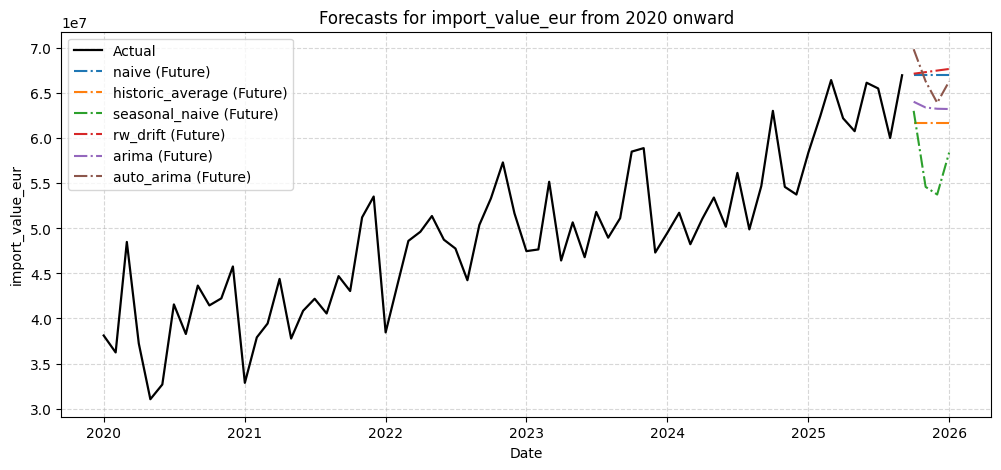

Saved baseline and statistical results separately


In [105]:
# Cell 6
results = basic_forecast_single_series(
    df,
    value_col="import_value_eur",
    date_col="date",
    forecast_methods=("naive","historic_average","seasonal_naive","rw_drift", "arima", "auto_arima"),
    h=12,
    season_length=12,
    export_csv=True
)


In [ ]:
# Cell 7
show_results(results)

,Model,Split,MAE,RMSE,MAPE,R2,OPE,family
0,naive,Val,5495278.167,6403134.639,0.113,-1.067,-9.831848,baseline
1,naive,Test,3018332.833,3730751.296,0.057,-0.005,-0.511619,baseline
2,historic_average,Val,6577216.333,7652794.591,0.134,-1.952,-13.300453,baseline
3,historic_average,Test,3021538.333,4153334.745,0.055,-0.246,-3.540808,baseline
4,seasonal_naive,Val,6223078.917,7108442.984,0.130,-1.547,-13.300453,baseline
5,seasonal_naive,Test,3725411.167,4073777.203,0.072,-0.198,-3.540808,baseline
6,rw_drift,Val,5040828.857,5931758.334,0.104,-0.774,-8.648095,statistical
7,rw_drift,Test,3226639.282,3784700.139,0.062,-0.034,1.047776,statistical
8,arima,Val,6644167.125,7699051.638,0.135,-1.988,-13.332149,statistical
9,arima,Test,3142610.369,4306469.283,0.057,-0.339,-4.054539,statistical


,Model,Split,MAE,RMSE,MAPE,R2,OPE,family
0,naive,Val,5495278.167,6403134.639,0.113,-1.067,-9.831848,baseline
1,naive,Test,3018332.833,3730751.296,0.057,-0.005,-0.511619,baseline
2,historic_average,Val,6577216.333,7652794.591,0.134,-1.952,-13.300453,baseline
3,historic_average,Test,3021538.333,4153334.745,0.055,-0.246,-3.540808,baseline
4,seasonal_naive,Val,6223078.917,7108442.984,0.130,-1.547,-13.300453,baseline
5,seasonal_naive,Test,3725411.167,4073777.203,0.072,-0.198,-3.540808,baseline
6,rw_drift,Val,5040828.857,5931758.334,0.104,-0.774,-8.648095,statistical
7,rw_drift,Test,3226639.282,3784700.139,0.062,-0.034,1.047776,statistical
8,arima,Val,6644167.125,7699051.638,0.135,-1.988,-13.332149,statistical
9,arima,Test,3142610.369,4306469.283,0.057,-0.339,-4.054539,statistical
